In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
import numpy as np
from astropy.io import fits
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
from io import BytesIO
%matplotlib inline

In [3]:
PATH = Path("/scratch/datasets/astro_deconv_2019_split/")
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1
LAMBDA = 100
EPOCHS = 200

In [4]:
def fits_open(path):
    return fits.open(str(path))[0].data.squeeze().astype(np.float32)

In [5]:
def load_fits(fits_file):
    def internal(data):
        return fits.open(BytesIO(data))[0].data.squeeze().astype(np.float32)[..., np.newaxis]
    blob = tf.io.read_file(fits_file)
    return tf.py_func(internal, [blob], tf.float32)

In [6]:
def make_dataset(glob):
    ds = tf.data.Dataset.list_files(str(glob), shuffle=False)
    ds = ds.map(load_fits)
    ds = ds.batch(1)
    return ds

In [7]:
def normalize(image):
    min_ = image.min()
    max_ = image.max()
    return ((image - min) / max) -1

In [8]:
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    #input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    #input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [9]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [10]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [11]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
          result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [13]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 43, 43, 64)
        downsample(128, 4), # (bs, 15, 15, 128)
        downsample(256, 4), # (bs, 5, 5, 256)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

In [17]:
def like_loss(predicted, target, psf):
    convolver = tf.squeeze(psf)[:, :, tf.newaxis, tf.newaxis]
    convolved = tf.nn.conv2d(predicted, convolver, [1, 1, 1, 1], "SAME")
    return tf.reduce_sum(tf.multiply(predicted, convolved - 2 * target)) 

In [18]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.squeeze(display_list[i]) * 0.5 + 0.5)  # restore range to 
        plt.axis('off')
    plt.show()

In [19]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [20]:
def train_step_likelyhood(input_image, target, psf):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_loss = like_loss(gen_output, target, psf)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        step = 0
        start = time.time()

        for input_image, target, psf in dataset:
            #train_step(input_image, target)
            train_step_likelyhood(input_image, target, psf)
            step += 1

            if (step + 1) % 30 == 0:
                clear_output(wait=True)
                test_input, test_target, _ = list(test_dataset.take(1))[0]
                generate_images(generator, test_input, test_target)
                duration = time.time()-start
                speed = step / duration
                print(f"step: {step + 1} epoch: {epoch + 1} duration: {duration:.2f}s step/s: {speed:.2f}\n")

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            


In [22]:
train_dirty_dataset = make_dataset(PATH / 'train/*-wsclean-dirty.fits')
train_skymodel_dataset = make_dataset(PATH / 'train/*-skymodel.fits')
train_psf_dataset = make_dataset(PATH / 'train/*-wsclean-psf.fits')
train_dataset = tf.data.Dataset.zip((train_dirty_dataset, train_skymodel_dataset, train_psf_dataset))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

test_dirty_dataset = make_dataset(PATH / 'test/*-wsclean-dirty.fits')
test_skymodel_dataset = make_dataset(PATH / 'test/*-skymodel.fits')
test_psf_dataset = make_dataset(PATH / 'test/*-wsclean-psf.fits')
test_dataset = tf.data.Dataset.zip((test_dirty_dataset, test_skymodel_dataset, test_psf_dataset))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [23]:
generator = Generator()
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                )

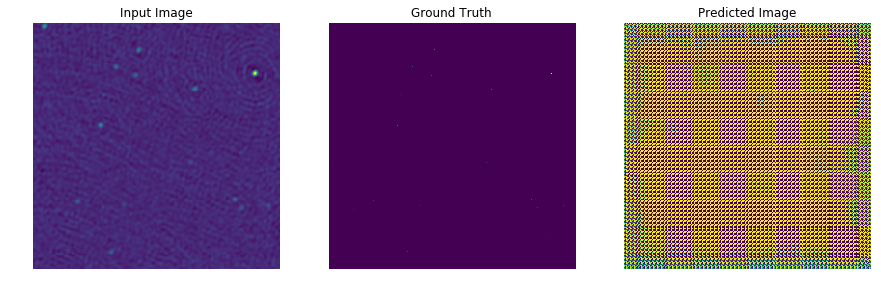

step: 1110 epoch: 1 duration: 511.34s step/s: 2.17



In [ ]:
train(train_dataset, 10)